# RNN model for Clothing Sales Time Series data

## Data Source

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('RSCCASN.csv', index_col='DATE', 
                 parse_dates=True)

In [4]:
df.columns = ['Sales']

In [5]:
df.head()

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [6]:
df.shape

(334, 1)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
Sales    334 non-null int64
dtypes: int64(1)
memory usage: 5.2 KB


In [8]:
df.index[0]     # confirm that the index is in datetime format

Timestamp('1992-01-01 00:00:00')

In [9]:
type(df.index[0])

pandas._libs.tslibs.timestamps.Timestamp

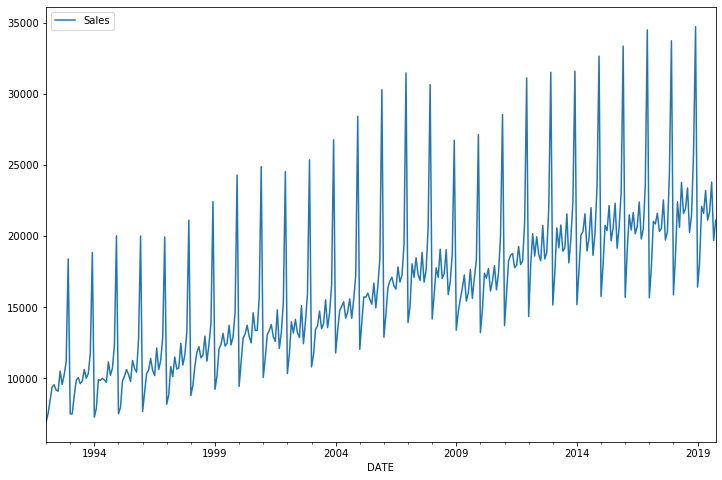

In [10]:
df.plot(figsize=(12,8))

## Train Test Split

In [11]:
len(df)

334

Data is recorded monthly, let's forecast 1.5 years (18 months) into the future.

In [12]:
test_size = 18
test_ind = len(df) - test_size
test_ind

316

In [13]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [14]:
train.shape

(316, 1)

In [15]:
test.shape

(18, 1)

## Scale Data

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [17]:
scaler = MinMaxScaler()

In [18]:
# we fit on the train set, and then transform on both train and test set
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [19]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [20]:
scaled_train.max()

1.0

In [21]:
scaled_test.max()

1.0081324426372351

# Create a Time Series Generator

A Time Series Generator is created and it's used as a data input to the RNN model in the correct data format.

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [22]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [24]:
# we define a length of 12 months of sales data for each sample data 
# and use that to predict the sales for the 13th month (next month)

# we believe using a length of 12 months is a reasonable choice to  
# capture the yearly cycle of sales data

length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                                length=length, batch_size=1)

validation_generator = TimeseriesGenerator(scaled_test, scaled_test, 
                                           length=length, batch_size=1)

In [25]:
len(scaled_train)

316

In [29]:
# there are 304 batches generated from the 316 scaled_train data
# because the initial 12 data points are reserved for training model
len(generator)

304

In [30]:
len(scaled_test)

18

In [31]:
# there are 6 batches generated from the 18 scaled_test data
len(validation_generator)

6

In [32]:
# use tuple unpacking to check on the first batch
X,y = generator[0]

In [35]:
print(f'Given 12 months data: \n{X}')
print()
print(f'Predict this y: \n {y}')

Given 12 months data: 
[[[0.        ]
  [0.02127505]
  [0.05580163]
  [0.08942056]
  [0.09512053]
  [0.08146965]
  [0.07860151]
  [0.12979233]
  [0.09566512]
  [0.1203892 ]
  [0.15426227]
  [0.41595266]]]

Predict this y: 
 [[0.02047633]]


### Create the Model

In [77]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [78]:
# We're only using one feature in our time series
n_features = 1

In [79]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

In [80]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and fitting the model

In [40]:
from tensorflow.keras.callbacks import EarlyStopping

In [81]:
early_stop = EarlyStopping(monitor='val_loss', patience=2,
                          restore_best_weights=True)

In [82]:
# fit model
model.fit(generator, epochs=20,
          validation_data=validation_generator,
          callbacks=[early_stop])

Epoch 1/20
322/322 [==============================] - 1s 4ms/step - loss: 0.0241 - val_loss: 0.0034
Epoch 2/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0171 - val_loss: 0.0020
Epoch 3/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0095 - val_loss: 0.0014
Epoch 4/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0036 - val_loss: 0.0069
Epoch 5/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0021 - val_loss: 5.2299e-04
Epoch 6/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 8.1743e-04
Epoch 7/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0014 - val_loss: 4.0784e-04
Epoch 8/20
322/322 [==============================] - 1s 3ms/step - loss: 9.9793e-04 - val_loss: 8.0630e-04
Epoch 9/20
322/322 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 5.7529e-04


In [83]:
losses = pd.DataFrame(model.history.history)
losses

,loss,val_loss
0,0.024074,0.003449
1,0.017069,0.001984
2,0.009488,0.001450
3,0.003637,0.006924
4,0.002108,0.000523
5,0.001396,0.000817
6,0.001412,0.000408
7,0.000998,0.000806
8,0.001250,0.000575


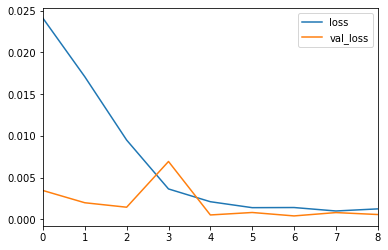

In [84]:
losses.plot()

In [85]:
model.evaluate(validation_generator, verbose=0)

0.0004078395722899586

## Evaluate on Test Data

Let's use a for loop to predict into the future for the entire test range. We will use the last 12 months of data from the train set to begin making prediction, then we will append the predicted values to the train set to make further prediction for future months.

In [86]:
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time step ahead 
    # ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop the first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]],
                              axis=1)

In [87]:
len(test_predictions)

18

## Inverse Transformations and Compare

In [97]:
test.head()

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260


In [98]:
true_predictions = scaler.inverse_transform(test_predictions)
test['Predictions'] = true_predictions

# incorporate the predictions into the test set for easy comparison

/Users/apple/anaconda3/envs/tf/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [99]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21623.261384
2018-06-01,21589,20470.369300
2018-07-01,21919,20682.696871
2018-08-01,23381,22523.050566
2018-09-01,20260,20016.663386
2018-10-01,21473,20652.001065
2018-11-01,25831,24530.129753
2018-12-01,34706,33378.042747
2019-01-01,16410,16253.380059


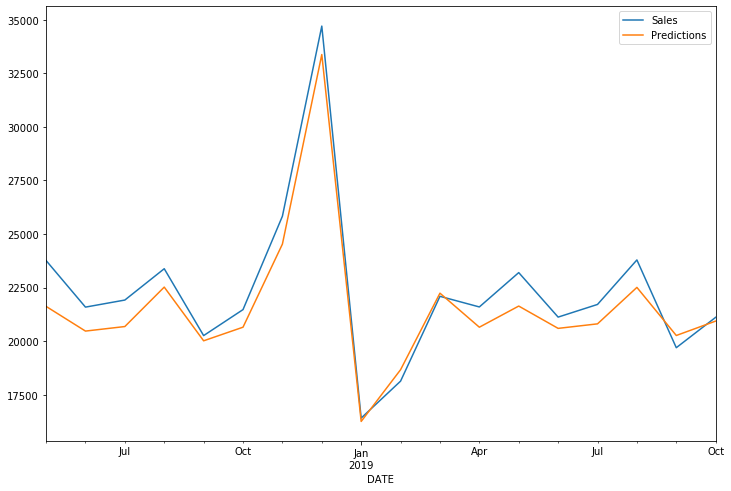

In [100]:
test.plot(figsize=(12,8))

In [101]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [102]:
mean_absolute_error(test['Sales'], test['Predictions'])

880.5292500125058

In [103]:
mean_squared_error(test['Sales'], test['Predictions'])

1058168.9656830302

In [104]:
np.sqrt(mean_squared_error(test['Sales'], test['Predictions']))

1028.6734008824328

# Retrain with full dataset and make Forecast

In [168]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [169]:
length = 12 # Length of the output sequences (in number of timesteps)
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, 
                                length=length, batch_size=1)

In [170]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(length, n_features)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')


# fit model without early_stop because there is no test set to compare error
model.fit_generator(generator, epochs=9)

Epoch 1/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0235
Epoch 2/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0156
Epoch 3/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0094
Epoch 4/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0045
Epoch 5/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0023
Epoch 6/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0020
Epoch 7/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0022
Epoch 8/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0016
Epoch 9/9
322/322 [==============================] - 1s 3ms/step - loss: 0.0011


In [171]:
losses = pd.DataFrame(model.history.history)
losses

,loss
0,0.023502
1,0.015566
2,0.009386
3,0.004512
4,0.002282
5,0.001983
6,0.002201
7,0.001575
8,0.001128


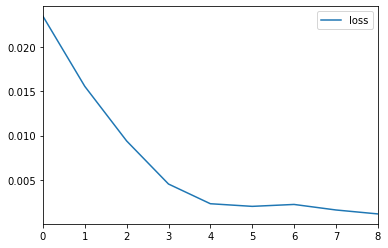

In [172]:
losses.plot()

In [173]:
forecast = []

periods = 12     # we will predict 12 months ahead

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead 
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]],
                              axis=1)

In [174]:
len(forecast)

12

In [175]:
forecast = scaler.inverse_transform(forecast)

### Creating new timestamp index with pandas.

In [176]:
df.tail()

,Sales
DATE,
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791
2019-09-01,19695
2019-10-01,21113


In [177]:
forecast_index = pd.date_range(start='2019-11-01', periods=periods,
                               freq='MS')

In [178]:
forecast_df = pd.DataFrame(data=forecast, index=forecast_index,
                           columns=['Forecast'])

In [179]:
forecast_df.head()

,Forecast
2019-11-01,26023.917340
2019-12-01,35474.158980
2020-01-01,17415.869816
2020-02-01,19302.267220
2020-03-01,22458.483809


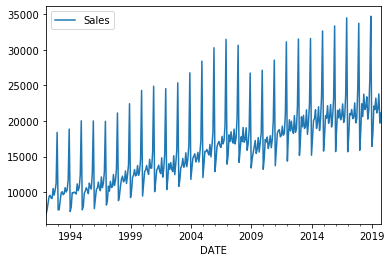

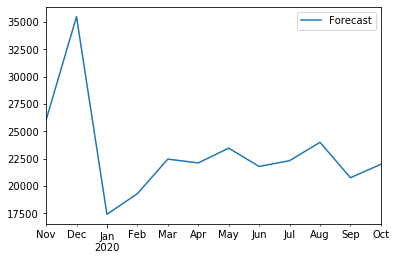

In [180]:
df.plot()
forecast_df.plot()

### Joining pandas plots

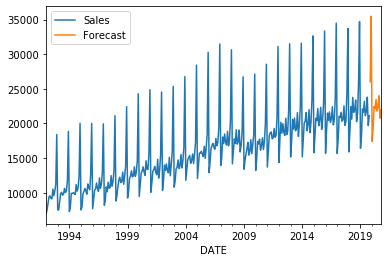

In [181]:
ax = df.plot()
forecast_df.plot(ax=ax)

(576, 611)

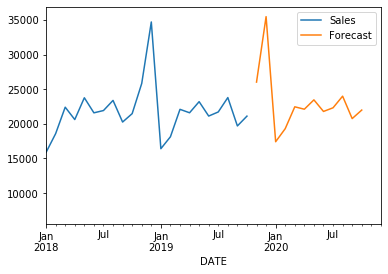

In [182]:
ax = df.plot()
forecast_df.plot(ax=ax)
plt.xlim('2018-01-01','2020-12-01')